In [10]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
import glob

### Camera calibration

In [ ]:
# Camera calibration step

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        print(write_name)
        #cv2.imwrite(write_name, img)
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.show()

In [ ]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('test_undist.jpg',dst)

In [ ]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

In [ ]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )
print('Data is stored to the pickle file under ./camera_cal/dist_pickle.p')

In [12]:
# Load the camera calibration result from pickle file
dist_pickle = pickle.load( open( "camera_cal/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
print('Data loading from pickle file is finished')

Data loading from pickle file is finished


In [ ]:
# Quick test
img = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
plt.savefig('report_images/calibration.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# Download an image
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Undistort it and show the result
image_dst = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(image_dst)
ax2.set_title('Undistorted Image', fontsize=20)
plt.savefig('report_images/undistortion.jpg', bbox_inches='tight')
plt.show()

### Image processing pipeline

In [11]:
src = np.float32([[0, 720], 
                  [575, 450],
                  [705, 450],
                  [1280, 720]])
dst = np.float32([[100, 720],
                  [100, 0],
                  [1280-100, 0], 
                  [1280-100, 720]])

In [88]:
def draw_mask(img, pts, color = (0, 255, 0)):
    image = np.copy(img)
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    return cv2.polylines(image, [pts],True, color, lineType = cv2.LINE_AA, thickness = 2)

def perspective(img, mode='f', scr=src, dst=dst):
    
    img_size = (img.shape[1], img.shape[0])
   
    if mode == 'f':
        M = cv2.getPerspectiveTransform(src, dst)
    elif mode == 'inv':
        M = cv2.getPerspectiveTransform(dst, src)
        
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

def undistortion(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def blur(img, k=5):
    kernel_size = (k, k)
    return cv2.GaussianBlur(img, kernel_size, 0)

def channel(img, ch):
    return img[:, :, ch]

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def rgb2lab(img, ch=-1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    if ch < 0:
        return img
    else:
        return img[:, :, ch]

def rgb2hls(img, ch=-1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if ch < 0:
        return img
    else:
        return img[:, :, ch]

def rgb2hsv(img, ch=-1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if ch < 0:
        return img
    else:
        return img[:, :, ch]

def rgb2yuv(img, ch=-1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if ch < 0:
        return img
    else:
        return img[:, :, ch]

def canny(img, thresh=(0, 255)):
    return cv2.Canny(img, thresh[0], thresh[1])

def sobel_abs(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def channel_thresholding(img, ch, thresh=(0, 255)):
    channel = img[:,:,ch]
    binary_output = np.zeros_like(channel)
    binary_output[(channel>thresh[0]) & (channel<=thresh[1])] = 1

    return binary_output

def plot(img, ch=-1, size=(5, 3), cmap=None, name=None):
    plt.figure(figsize=size)
    if ch < 0:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img[:, :, ch], cmap=cmap)
    if name:
        plt.savefig('report_images/' + name + '.jpg', bbox_inches='tight')
    plt.show()
    

def plot_many(imgs, cmaps=[], name=None):
    n = len(imgs)
    f, ax = plt.subplots(1, n, figsize=(n*10,5))
    for i in range(n):
        if not cmaps:
            ax[i].imshow(imgs[i])
        else:
            ax[i].imshow(imgs[i], cmap = cmaps[i])
    if name:
        plt.savefig('report_images/' + name + '.jpg', bbox_inches='tight')
    plt.show()

def yellow_select(img): 
    lower = np.array([15,120,120], dtype=np.uint8)
    upper = np.array([55,200,255], dtype=np.uint8)
    
    channel_h = img[:, :, 0]
    channel_l = img[:, :, 1]
    channel_s = img[:, :, 2]
    
    binary_output = np.zeros_like(img[:,:,0])
    binary_output[((channel_h > lower[0]) & (channel_h <= upper[0])) 
                  & ((channel_l > lower[1]) & (channel_l <= upper[1])) 
                  & ((channel_s > lower[2]) & (channel_s <= upper[2]))] = 1
    
    return binary_output

def white_select(img): 
    lower = np.array([0,210,0], dtype=np.uint8)
    upper = np.array([360,255,255], dtype=np.uint8)
    
    channel_h = img[:, :, 0]
    channel_l = img[:, :, 1]
    channel_s = img[:, :, 2]
    
    binary_output = np.zeros_like(img[:,:,0])
    binary_output[((channel_h > lower[0]) & (channel_h <= upper[0])) 
                  & ((channel_l > lower[1]) & (channel_l <= upper[1])) 
                  & ((channel_s > lower[2]) & (channel_s <= upper[2]))] = 1
    
    return binary_output

def weighted_img(initial_img, img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def sobel_dir(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    sobelx_abs = np.absolute(sobelx)
    
    ang_sobel = np.arctan2(np.absolute(sobely), sobelx_abs)    
    binary_output = np.zeros_like(ang_sobel)
    binary_output[(ang_sobel >= thresh[0]) & (ang_sobel <= thresh[1])] = 1
    
    return binary_output

def fit2_rls(x, y, lam):
    x = np.array(x)
    y = np.array(y)
    
    y = np.concatenate((y, np.array([0])))
    
    A = np.array([np.ones(x.shape[0]), x, x**2])
    A = np.vstack((A, np.array([0, 0, lam])))
    
    est = np.linalg.lstsq(a=A, b=y)[0]
    return est[::-1]

In [160]:
def pipeline(img, mtx=mtx, dist=dist):  
    global left_fit
    global right_fit
    
    img = undistortion(img=img, mtx=mtx, dist=dist)

    combined = np.zeros_like(channel(img, ch=0))
    combined[(channel_thresholding(rgb2lab(img), ch=2, thresh=(150, 255)) == 1) |
             (white_select(rgb2hls(img)) == 1) |
             (sobel_abs(rgb2gray(img), thresh=(30, 100)) == 1)] = 1
    
    combined_p = perspective(combined, 'f')
    
    b = np.mean(rgb2hsv(perspective(img), ch=2))
    detections, lines_warp, R, offset = search_lines(combined_p, beta=0.7)
    
    region_warp = draw_region(combined_p, left_fit, right_fit)

    region = perspective(region_warp, mode='inv')
    lines = perspective(lines_warp, mode='inv')
    
    # Combine the result with the original image
    img = cv2.addWeighted(img, 1, region, 0.3, 0)
    
    img = add_pic(img, detections)
    
    if offset < 0:
        offset_text = "Offset to the right: {:0.2f} m".format(offset)
    else:
        offset_text = "Offset to the left: {:0.2f} m".format(offset)
    
    test1 = np.abs(right_fit[2] - left_fit[2])
    test2 = np.abs(left_fit[0]*360**2 + left_fit[1]*360 + left_fit[2]
                   - right_fit[0]*360**2 - right_fit[1]*360 - right_fit[2])
    
    text = ["Radius of curvature: {:0.2f} m".format(R), offset_text, "Parameters: "]
    
    img = info_table(img, text)
    
    img = weighted_img(lines, img)
    
    return img

### Lines detection algorithm

In [16]:
# Additional routines

def add_pic(img, info_pic):
    img_size = (img.shape[1], img.shape[0])
    info_size = 300
    r = float(info_size / img_size[0])
    dim = (info_size, int(img_size[1] * r))
    info = cv2.resize(info_pic, dim)
    
    x_offset=y_offset=1
    cv2.rectangle(img, (0, 0), (info_size + 2, int(img_size[1] * r + 2)), (0,255,0), thickness = 1, lineType = cv2.LINE_AA)
    img[y_offset:y_offset+info.shape[0], x_offset:x_offset+info.shape[1]] = info
    return img

def info_table(img, text, size=(300, 100)):
    img_size = (img.shape[1], img.shape[0])
    length = size[0]
    width = size[1]
    
    cv2.rectangle(img, (img_size[0]-length+1, 0+1), (img_size[0]-1, width-1), (0,0,0), thickness = -1, lineType = cv2.LINE_AA)
    cv2.rectangle(img, (img_size[0]-length, 0), (img_size[0], width), (0,255,0), thickness = 1, lineType = cv2.LINE_AA)
    
    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(img, text[0], (img_size[0]-length + 10, width-10), font, 1, (0,255,0), 1, cv2.LINE_AA)
    
    cv2.putText(img, text[1], (img_size[0]-length + 10, width-40), font, 1, (0,255,0), 1, cv2.LINE_AA)
    
    cv2.putText(img, text[2], (img_size[0]-length + 10, width-70), font, 1, (0,255,0), 1, cv2.LINE_AA)
    return img

def bin2rgb(warped_binary):
    return np.asarray(np.dstack((warped_binary, warped_binary, warped_binary))*255, dtype=np.uint8)

def plot2nparray(vector, my_dpi = 96):    
    fig = plt.figure(figsize=(300/my_dpi, 168/my_dpi), dpi=my_dpi)
    ax = fig.add_subplot(111)
    ax.plot(vector)
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()
    return data

def draw_region(warped, left_fit, right_fit):
    img_x = warped.shape[1]
    img_y = warped.shape[0]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_y-1, img_y )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    center_fit = (left_fit + right_fit)/2
    center_fitx = center_fit[0]*ploty**2 + center_fit[1]*ploty + center_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_center = np.array([np.flipud(np.transpose(np.vstack([center_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_center))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (255, 0, 0))
    
    ## Recast the x and y points into usable format for cv2.fillPoly()
    pts_center = np.array([np.transpose(np.vstack([center_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_center, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,0, 255))

    return color_warp

In [161]:
# Initialisation of global variables
left_fit = np.zeros(3)
right_fit = np.zeros(3)
curvature = 0
offset = 0

In [157]:
def detect_lines(image, nwindows = 9, window_width = 50, alpha=0.9):
    
    # Bunch of global vars
    global left_fit
    global right_fit
    global curvature
    global offset
    
    img_size = (image.shape[1], image.shape[0])
    img_x = image.shape[1]
    img_y = image.shape[0]
    
    # Identify the x and y positions of all nonzero pixels in the image
    img_nonzero = image.nonzero()
    nonzeroy = np.array(img_nonzero[0])
    nonzerox = np.array(img_nonzero[1])
    
    window_height = np.int(img_y/nwindows)
    center = int(img_x/2)
    
    # Create an output images to draw on and visualize the result
    out_img = np.dstack((image, image, image))*255
    lines_img = np.zeros_like(out_img)
    
    # Set parameters of windows
    w = np.ones(window_width)
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*img_y/4):,:center], axis=0)
    conv_l = np.convolve(w, l_sum, 'same')
    l_distr = conv_l/np.max(conv_l)
    leftx_base = np.argmax(l_distr)        

    r_sum = np.sum(image[int(3*img_y/4):,center:], axis=0)
    conv_r = np.convolve(w, r_sum, 'same')
    r_distr = conv_r/np.max(conv_r)
    rightx_base = np.argmax(r_distr)+center
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    alpha = 0.9
    #conv_image = np.zeros(img_x)
    # Step through the windows one by one
    for level in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_y - (level+1)*window_height
        win_y_high = img_y - level*window_height
        win_xleft_low = max(0, leftx_current - margin)
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = min(rightx_current + margin, img_x)
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on the coordinate corresponding to the maximum of convolution
        if len(good_left_inds) > minpix:
            img_layer = image[win_y_low:win_y_high, win_xleft_low:win_xleft_high]
            img_layer_hist = np.sum(img_layer, axis=0)
            conv_left = np.convolve(w, img_layer_hist, 'same')
            mean = np.argmax(conv_left) + win_xleft_low
            leftx_current = np.int(alpha*mean + (1-alpha)*leftx_current)
            
        if len(good_right_inds) > minpix:
            img_layer = image[win_y_low:win_y_high, win_xright_low:win_xright_high]
            img_layer_hist = np.sum(img_layer, axis=0)
            conv_right = np.convolve(w, img_layer_hist, 'same')
            mean = np.argmax(conv_right) + win_xright_low
            rightx_current = np.int(alpha*mean + (1-alpha)*rightx_current)    

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    curvature, offset = lane_params(left_fit, right_fit, lefty, righty)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    lines_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    lines_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, lines_img, curvature, offset

In [19]:
def lane_params(left_fit, right_fit, lefty, righty, center=1280/2, y_eval=720, ym_per_pix=24/720, xm_per_pix=3.7/750):
    
    left_line_bottom = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_line_bottom = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    offset = ((right_line_bottom + left_line_bottom)/2 - center)*xm_per_pix

    ploty = np.linspace(0, 720-1, num=720)
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curvature = (left_curverad*len(lefty) + right_curverad*len(righty))/(len(lefty) + len(righty))
    
    return curvature, offset

In [158]:
def search_lines(image, margin=100, beta=0.1):
    # Bunch of global vars
    global left_fit
    global right_fit
    global curvature
    global offset
    
    if not np.any(left_fit) or not np.any(right_fit):
        return detect_lines(image)
    else:
        out_img = np.dstack((image, image, image))*255
        lines_img = np.zeros_like(out_img)
        window_img = np.zeros_like(out_img)

        nonzeroy = np.array(image.nonzero()[0])
        nonzerox = np.array(image.nonzero()[1])

        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        lines_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        lines_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        
        left_fit = beta*fit2_rls(lefty, leftx, 10**6) + (1-beta)*left_fit
        #left_fit = beta*np.polyfit(lefty, leftx, 2) + (1-beta)*left_fit  
        right_fit = beta*fit2_rls(righty, rightx, 10**6) + (1-beta)*right_fit
        #right_fit = beta*np.polyfit(righty, rightx, 2) + (1-beta)*right_fit
       
        curvature, offset = lane_params(left_fit, right_fit, lefty, righty)

        # Generate x and y values for plotting
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
    return result, lines_img, curvature, offset

In [162]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



100%|█████████▉| 1260/1261 [03:31<00:00,  6.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7min 7s, sys: 3.01 s, total: 7min 10s
Wall time: 3min 32s


In [163]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [116]:
# Extract frames from video
import os
from moviepy.editor import *

def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        imgpath = os.path.join(imgdir, '{}.png'.format(t))
        clip.save_frame(imgpath, t)

movie = "project_video.mp4"
imgdir = "test_images"
times = 24.3, 24,7

extract_frames(movie, times, imgdir)

### Extra routines for the report

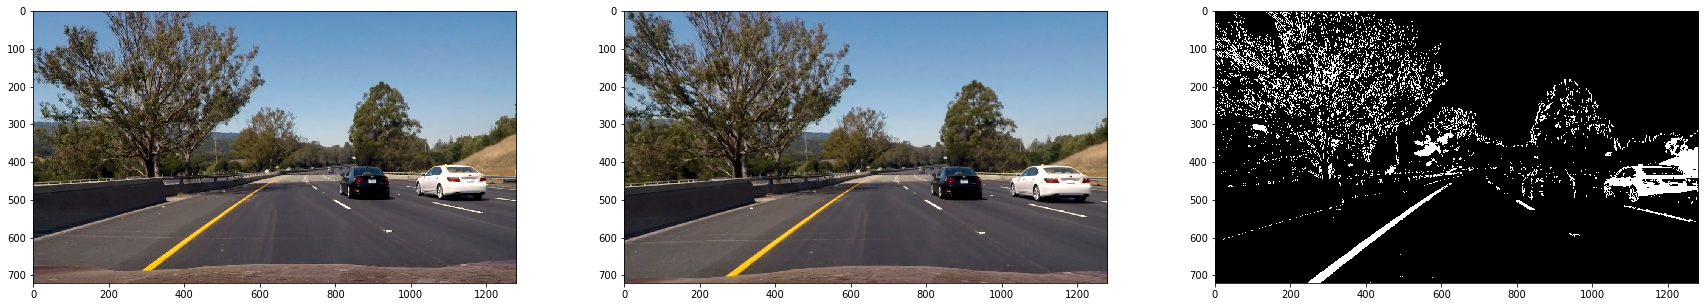

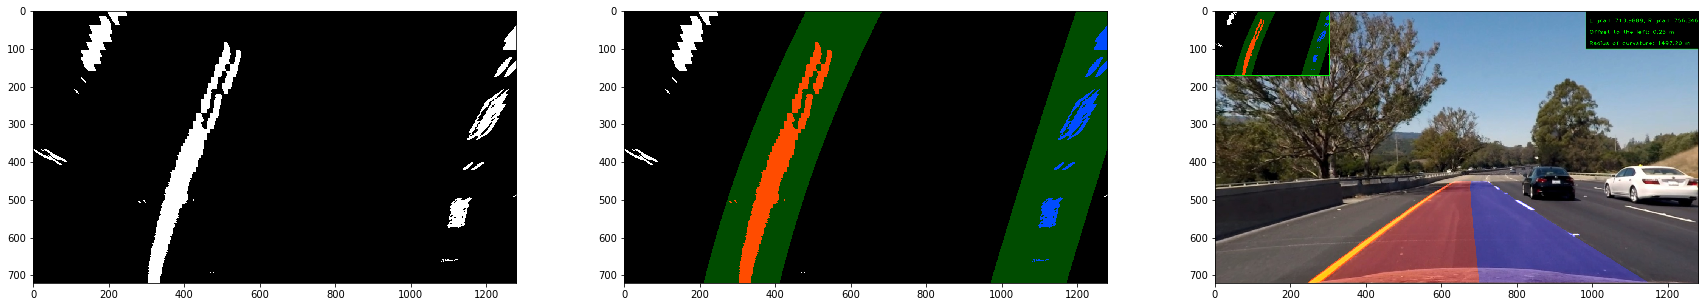

In [155]:
# for report
test = bgr2rgb(cv2.imread('test_images/test6.jpg'))
test_und = undistortion(img=test, mtx=mtx, dist=dist)

for i in range(100):
    img, comb, comb_p, det = pipeline(test_und)

plot_many([test, test_und, comb], cmaps=[None, None, 'gray'], name='pipeline1_3')
plot_many([comb_p, det, img], cmaps=['gray', None, None], name='pipeline4_6')

In [ ]:
# for report
test = cv2.imread('test_images/test6.jpg')
test_und = undistortion(img=bgr2rgb(test), mtx=mtx, dist=dist)
combined1 = np.zeros_like(channel(test_und, ch=0))
combined1[(channel_thresholding(rgb2lab(test_und), ch=2, thresh=(150, 255)) == 1)] = 1

combined2 = np.zeros_like(channel(test_und, ch=0))
combined2[(channel_thresholding(rgb2lab(test_und), ch=2, thresh=(150, 255)) == 1) | 
          (white_select(rgb2hls(test_und)) == 1) ] = 1

combined3 = np.zeros_like(channel(test_und, ch=0))
combined3[(channel_thresholding(rgb2lab(test_und), ch=2, thresh=(150, 255)) == 1) |
          (white_select(rgb2hls(test_und)) == 1) |
          (sobel_abs(rgb2gray(test_und), thresh=(30, 100)) == 1)] = 1

plot_many([test_und, combined1, combined2, combined3], cmaps=[None, 'gray', 'gray', 'gray'], name='thresh_bin_img')

In [ ]:
# for report
test = cv2.imread('test_images/test4.jpg')
test_und = undistortion(img=bgr2rgb(test), mtx=mtx, dist=dist)
combined1 = np.zeros_like(channel(test_und, ch=0))
combined1[(channel_thresholding(rgb2lab(test_und), ch=2, thresh=(150, 255)) == 1)] = 1

combined2 = np.zeros_like(channel(test_und, ch=0))
combined2[(channel_thresholding(rgb2lab(test_und), ch=2, thresh=(150, 255)) == 1) | 
          (white_select(rgb2hls(test_und)) == 1) ] = 1

combined3 = np.zeros_like(channel(test_und, ch=0))
combined3[(channel_thresholding(rgb2lab(test_und), ch=2, thresh=(150, 255)) == 1) |
          (white_select(rgb2hls(test_und)) == 1) |
          (sobel_abs(rgb2gray(test_und), thresh=(30, 100)) == 1)] = 1

plot_many([test_und, combined1, combined2, combined3], cmaps=[None, 'gray', 'gray', 'gray'], name='thresh_bin_img')


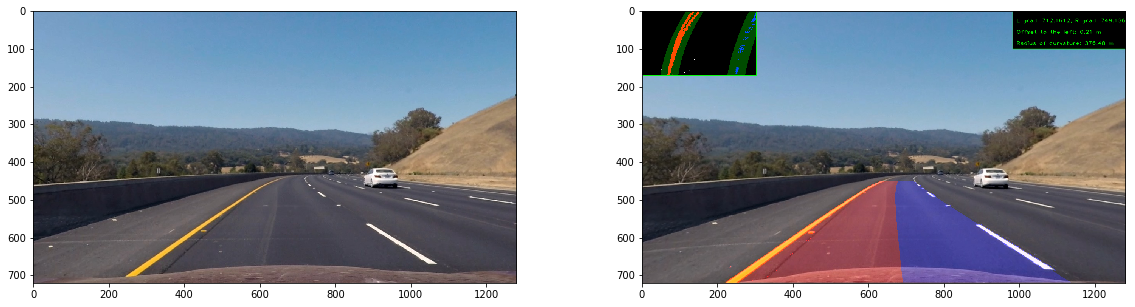

In [159]:
# for report
test = cv2.imread('test_images/test3.jpg')
test_und = undistortion(img=bgr2rgb(test), mtx=mtx, dist=dist)
plot_many([test_und, pipeline(test_und)], name = 'pipeline_area1')

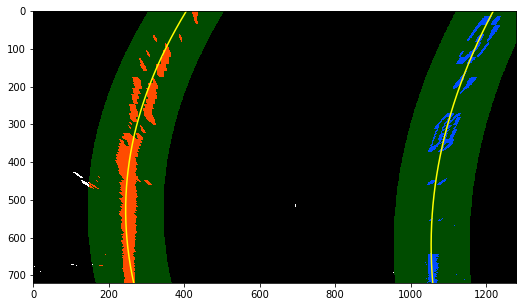

In [153]:
# for report
img_pip = pipeline(test_und)
ploty = np.linspace(0, 719, 720)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(figsize=(10, 5))
plt.imshow(img_pip)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('report_images/pipeline.jpg')
plt.show()

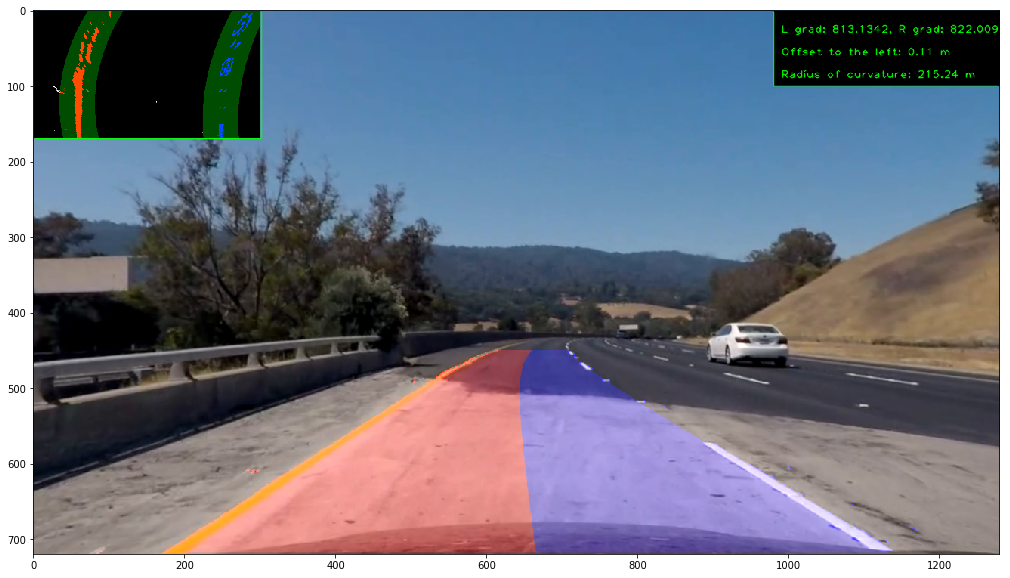

In [126]:
# Tests

test = bgr2rgb(cv2.imread('test_images/24.3.png'))
#test = bgr2rgb(cv2.imread('test_images/test1.jpg'))
test_und = undistortion(img=test, mtx=mtx, dist=dist)

plot(pipeline(test_und), size=(20, 10))

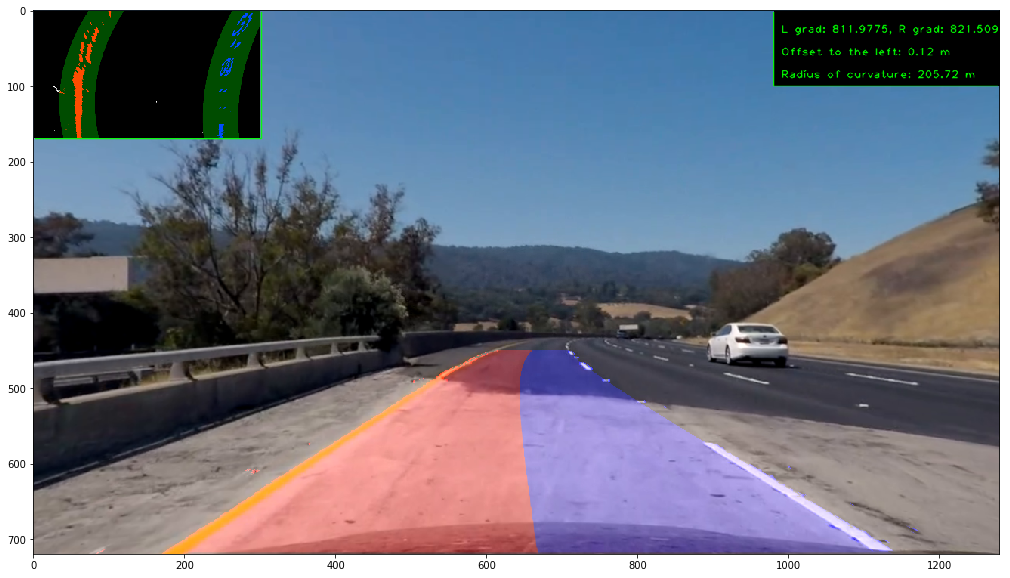

In [132]:
test = bgr2rgb(cv2.imread('test_images/24.3.png'))
#test = bgr2rgb(cv2.imread('test_images/test1.jpg'))
test_und = undistortion(img=test, mtx=mtx, dist=dist)

plot(pipeline(test_und), size=(20, 10))

In [ ]:
# Tests
#test = bgr2rgb(cv2.imread('test_images/test5.jpg'))
test_set = glob.glob('challenge_images/*.png')
for sample in test_set:
    test = cv2.imread(sample)
    test_und = undistortion(img=bgr2rgb(test), mtx=mtx, dist=dist)

    combined = np.zeros_like(channel(test, ch=0))
            #(sobel_abs(rgb2gray(test_und), thresh=(20, 100)) == 1) |
            #(sobel_dir(rgb2hls(test_und, ch=2), thresh=(0.5, 1.3)) == 1)] = 1

    plot_many([test_und, perspective(test_und)], cmaps=[None, None, 'gray'])
    print(np.mean(channel(test_und, ch=2)))

In [ ]:
# Tests
#test = cv2.imread('test_images/test2.jpg')
#test = cv2.imread('challenge_images/0.63.png')
test_set = glob.glob('test_images/*.jpg')
#test_set = glob.glob('challenge_images/*.png')
for i, sample in enumerate(test_set):
    test = cv2.imread(sample)
    test_und = undistortion(img=bgr2rgb(test), mtx=mtx, dist=dist)
    test_x = sobel_abs(rgb2gray(test_und), thresh=(20, 100))
    
    test_yellow = yellow_select(rgb2hls(test_und))
    test_white = white_select(rgb2hls(test_und))
    plot_many([test_und, pipeline(test_und)], name = 'pipeline_test_images_'+str(i)+'.jpg')

In [ ]:
# for report
test = cv2.imread('test_images/straight_lines1.jpg')
test_und = undistortion(img=bgr2rgb(test), mtx=mtx, dist=dist)
plot_many([draw_mask(test_und, src), draw_mask(perspective(test_und), dst)], name='region1')

In [ ]:
def f(x):
    return 0.8/np.sqrt(1+0.01*(x-90)**2)

def f1(x):
    return 90/x**2

x = np.linspace(50, 180, 1000)
plt.figure(figsize=(10,5))
plt.plot(x, f(x))
plt.grid()
plt.xlabel('Brightness')
plt.ylabel('Filtering coefficient - beta')
plt.savefig('report_images/beta.jpg', bbox_inches='tight')
plt.show()

In [ ]:
print("{:0.2f}".format(left_fit))